In [1]:
from dataclasses import dataclass
import pandas as pd
import os
import SimpleITK as sitk

import keras as tfk
from keras import layers as tfkl

import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.data import Dataset as tfds
from sklearn.model_selection import train_test_split

sns.set_theme()

In [2]:
SEED = 42
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
METRICS = ["accuracy", "recall", "f1_score"]

tfk.utils.set_random_seed(SEED)

In [3]:
@dataclass
class Hyperparameters:
    # Model
    activation = "silu"
    # Training
    noise_std: float = 0.05
    optimiser = tfk.optimizers.AdamW
    learning_rate = 3e-5
    regularization1 = tfk.regularizers.L1L2(l1=1e-5, l2=0) #1e-4
    regularization2 = tfk.regularizers.L1L2(l1=0, l2=0)
    loss = tfk.losses.CategoricalCrossentropy()
    epochs = 20
    ## Early stopping parameters
    es_patience = 10
    es_min_delta = 1e-2
    ## Learning rate schedule
    lr_patience = 5
    lr_decay_factor = 0.1
    lr_min_delta = 3e-2 
    min_lr = 1e-8

hp = Hyperparameters()

In [4]:
def load_nrrd(file_path):
    try:
        image = sitk.ReadImage(file_path)
        array = sitk.GetArrayFromImage(image)
        return array
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

In [5]:
datafile_path = "/kaggle/input/lung-tumor-ds/dataset_lung.xlsx"
image_dir = "/kaggle/input/lung-tumor-ds/Train"
dataset = pd.read_excel(datafile_path)

full_slices = []
nodule_slices = []
labels = []

for idx, row in dataset.iterrows():
    full_slice_path = os.path.join(image_dir, row['Full_slice'])
    nodule_path = os.path.join(image_dir, row['Nodule'])
    label = row['TumorClass']

    # Load full slice
    try:
        full_slice = load_nrrd(full_slice_path)
        nodule = load_nrrd(nodule_path)

        # Append data
        full_slices.append(full_slice)
        nodule_slices.append(nodule_path)
        labels.append(label)
    except Exception as e:
        print(f"Error loading {full_slice_name} or {nodule_name}: {e}")

In [6]:
full_slices = np.array(full_slices)
nodule_slices = np.array(nodule_slices)
labels = np.array(labels)

#X_train, X_test_val, y_train, y_test_val = train_test_split(full_slices, 
#                                                            labels, 
#                                                            test_size=0.2, 
#                                                            random_state=42)

#X_val, X_test, y_val, y_test = train_test_split(X_test_val,
#                                                y_test_val,
#                                                test_size=0.25, 
#                                                random_state=42) 

X_train, X_test, y_train, y_test = train_test_split(full_slices,
                                                    labels, 
                                                    test_size=0.1, 
                                                    random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
#print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (2126, 512, 512) (2126,)
Test set shape: (237, 512, 512) (237,)


In [7]:
def build_model(hp: Hyperparameters,
                feature_extractor: tfk.applications):
    inputs = tfkl.Input((512, 512, 3))

    #x = tfk.layers.Rescaling(1.0 / 255)(x)
    #x = tfkl.GaussianNoise(hp.noise_std)(x)
    #x = tfk.layers.Rescaling(255)(x)

    x = vgg19(inputs)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.6)(x)
    x = tfkl.Dense(256, activation=hp.activation, kernel_regularizer=hp.regularization1)(x)
    x = tfkl.Dense(128, activation=hp.activation, kernel_regularizer=hp.regularization2)(x)
    x = tfkl.Dense(64, activation=hp.activation)(x)
    x = tfkl.Dropout(0.3)(x)
    output = tfkl.Dense(5, activation="softmax")(x)

    model = tfk.Model(inputs, output)
    return model

In [8]:
def fit(model: tfk.Model,
        train_dataset: tf.data.Dataset,
        val_dataset: tf.data.Dataset,
        hp: Hyperparameters):
    model.compile(loss=hp.loss,
                  optimizer=hp.optimiser(learning_rate=hp.learning_rate), 
                  metrics=['accuracy'])
    
    history = model.fit(
        x=train_dataset,
        epochs=hp.epochs,
        #validation_data=val_dataset,
        validation_split=0.15,
        callbacks=[
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', 
                                        mode='max',
                                        patience=hp.es_patience, 
                                        restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(
                factor=hp.lr_decay_factor,
                patience=hp.lr_patience,
                min_delta=hp.lr_min_delta,
                min_lr=hp.min_lr,
                verbose=1,
            )
    ]
    
    ).history

    return model, history

In [9]:
from PIL import Image

X_train = [np.stack((img,)*3, axis=-1) for img in X_train] 
X_test = [np.stack((img,)*3, axis=-1) for img in X_test] 

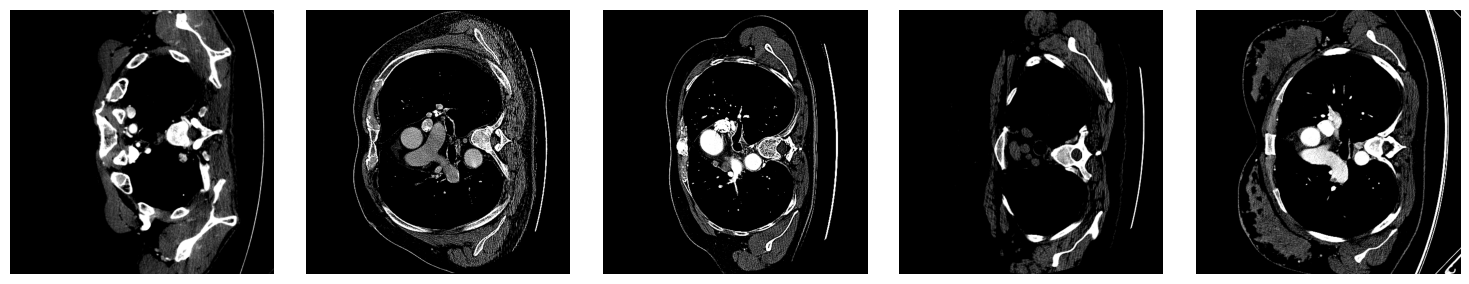

In [10]:
import matplotlib.pyplot as plt

num_images = 5

fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

# Plot each image
for i in range(num_images):
    ax = axes[i]
    ax.imshow(X_train[i])
    ax.axis('off')  # Turn off axes

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
vgg19 = tfk.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(512,512,3),
    pooling='avg'
)

model = build_model(hp, vgg19)

vgg19.trainable = False

model, history = fit(model, train_dataset, hp)